<a href="https://colab.research.google.com/github/braginkit/neural-networks-with-Python/blob/main/news__clusterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from datetime import datetime
from bs4 import BeautifulSoup

In [ ]:
base_url = 'https://www.starhit.ru/novosti/'
url_format = '/{}/{}/{}/'

In [ ]:
def get_links(date):
  h3s=BeautifulSoup(
      requests.get("https://www.starhit.ru/novosti/{:04d}/{:02d}/{:02d}/".format(
          date.year,
          date.month,
          date.day,
      )).text, "html5lib"
  ).find_all("h3")
  links=["https://www.starhit.ru/novosti/"+l.find_all("a")[0]["href"] for l in h3s]
  return links

def sanitize(text):
  text = bytes(text, 'utf-8').decode('utf-8', 'ignore')
  text.replace('\n', ' ')
  return text

def get_new(link):
  res = requests.get(link)
  bs = BeautifulSoup(res.text, "html5lib")
  aTitle=bs.h1.text.replace("\xa0", " ")
  anArticle=BeautifulSoup(
      " ".join([p.text for p in bs.find_all("p")]), "html5lib"
  ).get_text().replace("\xa0", " ")
  cat = next(
      a
      for a in bs.find_all('a')
      if a.get('class') and a.get('class')[0].endswith('b-header__block')
  ).text
  return sanitize(cat), sanitize(aTitle), sanitize(anArticle)

In [ ]:
import csv
import io
from datetime import timedelta

with io.open('lenta.csv', "w", encoding="utf-8") as f:
  writer = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
  writer.writerow(('class', 'title', 'text'))

  date = datetime.today()
  count = 0
  maxcount = 1000
  i = 0
  try:
    links = get_links(date)
    while count < maxcount:
      for l in links:
        print(f'[{count}/{maxcount}]', l)
        count += 1
        writer.writerow(get_new(l))
  except Exception as e:
    print(e)

In [ ]:
import json
import pandas as pd

with open("lenta.csv", encoding="utf-8") as newsfile:
  df = pd.read_csv(newsfile)

In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df.head()

,class,title,text
0,Мир,ХАМАС назвал сроки и условия для перемирия с И...,Соглашение о перемирии между Палестиной и Изра...
1,Наука и техника,Аналог Су-57 ВВС США получит «очень большую» р...,Истребитель F-15EX Eagle II Военно-воздушных с...
2,Мир,Блинкен назвал цель США в отношениях с Россией,"Госсекретарь США Энтони Блинкен заявил, что Ва..."
3,Ценности,Ирина Шейк снялась в стрингах и подверглась кр...,Российская супермодель Ирина Шейк снялась полу...
4,Мир,Названы попадающие под санкции США из-за «Севе...,США намерены ввести санкции против четырех рос...


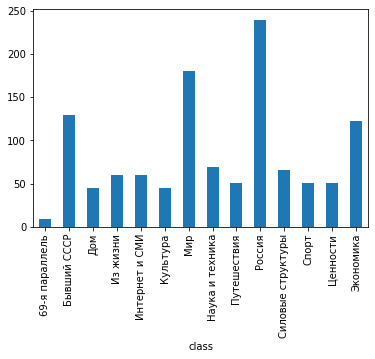

In [ ]:
import matplotlib.pyplot as plt
cats = df.groupby('class')['class'].count()
cats.plot.bar(ylim=0)
plt.show()

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
words = stopwords.words("russian")
df['cleaned'] = df.text.apply(
    lambda x: " ".join(
        [stemmer.stem(i)
         for i in re.findall(
            '[A-Za-zА-ЯЁа-яё]+-[A-Za-zА-ЯЁа-яё]+|[A-Za-zА-ЯЁа-яё]+', x
        ) if i not in words]
    ).lower()
)
df.cleaned.head()

0    соглашение перемирии палестиной израилем дости...
1    истребитель f ex eagl ii военно-воздушных сил ...
2    госсекретарь сша энтони блинкен заявил вашингт...
3    российская супермодель ирина шейк снялась полу...
4    сша намерены ввести санкции против четырех рос...
Name: cleaned, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

n_features = 20

vectorizer = TfidfVectorizer(
    norm='l2',
)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import MiniBatchKMeans, KMeans

import pickle
import numpy as np

In [ ]:
crit=[]

for k in range(10, 20):
  kmeans = KMeans(n_clusters=k,  init='random', n_init=10, verbose=1, n_jobs=-1)
  kmeans.fit(X)
  crit.append(kmeans.inertia_)

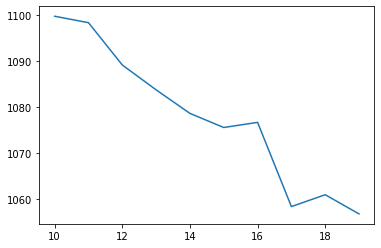

In [ ]:
plt.plot(range(10, 20), crit)

In [ ]:
labels = df['class']
X = df['cleaned']

X = vectorizer.fit(X).transform(X)

model = KMeans(n_clusters=15, init='random', n_init=10, verbose=1, n_jobs=-1)

In [ ]:
Y = model.fit(X)
print(adjusted_rand_score(labels, model.labels_))

0.08517759956442582
